## SETUP

In [1]:
!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 2.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 5.2 MB/s eta 0:00:0000:0100:01
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
!pip install spacy

  Using cached pydantic-2.7.0-py3-none-any.whl.metadata (103 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached pydantic_core-2.18.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.5 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 7.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 8.0 MB/s eta 0:00:00
Using cached pydantic-2.7.0-py3-none-any.whl (407 kB)
Using cached pydantic_core-2.18.1-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.4/486.4 kB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 8.3 MB/s eta 0:00:00a 0:00:01
   

In [13]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File doesn't exist, downloading...
The file has been downloaded and saved as human-nutrition-text.pdf


## Document preprocessing

In [14]:
# pdf tool
import fitz
from tqdm.auto import tqdm

def text_formatter(text:str):
    """Peforms minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    # if there actions needed, put them here
    return cleaned_text

def open_and_read_pdf(pdf_path:str):
    """
    Open a PDF file, reads its text content page by page, and collects statistics
    Parameters:
        file_path(str):The file path to the pdf document to be opened and read
    Returns:
        list:A list of dictionaries, each containing the follows:(for each page)
        - page number(adjusted if needed)
        - character count
        - word count
        - sentence count
        - token count
        - extracted text
    """
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in enumerate(doc):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append(
            {
                "page_number": page_number - 41,
                "page_char_count": len(text),
                "page_word_count": len(text.split(" ")),
                "page_sentence_count_raw": len(text.split(". ")),
                "page_token_count": len(text) / 4, # 1 token = ~4 chars
                "text": text
            }
        )
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path)
pages_and_texts[:2]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [15]:
import random
random.sample(pages_and_texts, k=2)

[{'page_number': 695,
  'page_char_count': 1239,
  'page_word_count': 203,
  'page_sentence_count_raw': 14,
  'page_token_count': 309.75,
  'text': 'Fluoride  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Fluoride’s Functional Role  Fluoride is known mostly as the mineral that combats tooth decay.  It assists in tooth and bone development and maintenance. Fluoride  combats tooth decay via three mechanisms:  1. Blocking acid formation by bacteria  2. Preventing demineralization of teeth  3. Enhancing remineralization of destroyed enamel  Fluoride was first added to drinking water in 1945 in Grand Rapids,  Michigan; now over 60 percent of the US population consumes  fluoridated drinking water. The Centers for Disease Control and  Prevention (CDC) has reported that fluoridation of water prevents,  on average, 27 percent of cavities in children and between 20 and 40  percent of cavities in adults. The CDC considers water fluoridation 

In [16]:
# explore the informations
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [21]:
# get stats
df.describe().round(2)

# check the token count becauser the embedding model always have token limits

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


In [22]:
# use spacy to break our text into sentences
from spacy.lang.en import English

# create a nlp instance
nlp = English()

# add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# create a document instance as an example
doc = nlp("hello, this is sally.")
assert len(list(doc.sents)) == 1

# access the sentence of the document
list(doc.sents)

[hello, this is sally.]

In [25]:
# run pipeline on pages of text
for item in pages_and_texts:
    # get the sentences
    item["sentences"] = list(nlp(item["text"]).sents)
    # make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    # count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

In [26]:
# inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 117,
  'page_char_count': 1226,
  'page_word_count': 221,
  'page_sentence_count_raw': 8,
  'page_token_count': 306.5,
  'text': 'The Muscular System  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  The muscular system allows the body to move voluntarily, but it  also controls involuntary movements of other organ systems such  as heartbeat in the circulatory system and peristaltic waves in the  digestive system. It consists of over six hundred skeletal muscles,  as well as the heart muscle, the smooth muscles that surround  your entire alimentary canal, and all your arterial blood vessels (see  Figure 2.24 “The Muscular System in the Human Body”). Muscle  contraction relies on energy delivery to the muscle. Each movement  uses up cellular energy, and without an adequate energy supply,  muscle function suffers. Muscle, like the liver, can store the energy  from glucose in the large polymeric molecule glycogen. But un

In [27]:
# put it into dataframe again and get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


## Chunking sentences into small groups
- Langchain can do this easily but let's prectice with python

In [28]:
# define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# create a function that recursively splits a list into desired sizes
def split_list(input_list:list, slice_size:int):
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# loop through pages_and_texts and split sentences input chunks
for item in pages_and_texts:
    item["sentence_chunks"] = split_list(
        input_list = item["sentences"],
        slice_size = num_sentence_chunk_size
    )
    item["num_chunks"] = len(item["sentence_chunks"])

In [30]:
# inspect some examples
random.sample(pages_and_texts, k=1)

[{'page_number': 890,
  'page_char_count': 1809,
  'page_word_count': 310,
  'page_sentence_count_raw': 21,
  'page_token_count': 452.25,
  'text': 'and tend to eat more meals away from home. Older adolescents  also can be curious and open to new ideas, which includes trying  new kinds of food and experimenting with their diet. For example,  teens will sometimes skip a main meal and snack instead. That is  not necessarily problematic. Their choice of food is more important  than the time or place.  However, too many poor choices can make young people  nutritionally vulnerable. Teens should be discouraged from eating  fast food, which has a high fat and sugar content, or frequenting  convenience stores and using vending machines, which typically  offer poor nutritional selections. Other challenges that teens may  face include obesity and eating disorders. At this life stage, young  people still need guidance from parents and other caregivers about  nutrition-related matters. It can be h

In [31]:
# create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


## Create Chunk dict for embedding later

In [35]:
import re

# split each chunk into its own item
pages_and_chunks = []

for item in pages_and_texts:
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # join the sentences together like they are strings
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # .A -> . A
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # other info
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

# get the num of chunks
len(pages_and_chunks)

1843

In [36]:
# inspect random samples
random.sample(pages_and_chunks, k=1)

[{'page_number': 618,
  'sentence_chunk': 'Drinkwater B, Bruemner B, Chesnut C. (1990). Menstrual History As a Determinant of Current Bone Density in Young Athletes. The Journal of the American Medical Association,\xa0263(4), 545–8.http:/ /www.ncbi.nlm.nih.gov/ pubmed/2294327?dopt=Abstract. . Accessed November 22, 2017. 3.\xa0Marcus R. et al. (1985). Menstrual Function and Bone Mass in Elite Women Distance Runners: Endocrine and Metabolic Features. The Annuals of Internal Medicine,\xa0102(2), 58–63.',
  'chunk_char_count': 452,
  'chunk_word_count': 59,
  'chunk_token_count': 113.0}]

In [37]:
# check stats
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [38]:
# some chunk have less than 30 tokens, let's check for samples to see if we need to keep them
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

Chunk token count: 24.5 | Text: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=225 330 | Digestion and Absorption of Lipids
Chunk token count: 23.75 | Text: view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=153   194 | Chloride
Chunk token count: 10.5 | Text: 442 | Health Consequences of Alcohol Abuse
Chunk token count: 13.0 | Text: Accessed September 22, 2017. 478 | Weight Management
Chunk token count: 16.75 | Text: PART XI CHAPTER 11. TRACE MINERALS Chapter 11. Trace Minerals | 649


In [39]:
# filter data
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

## Embedding text chunks
- choose a right model is not easy.
- can check [Hugging face leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
- A good blog, with many ways for chunking : [Chunking Strategies for LLM Applications](https://www.pinecone.io/learn/chunking-strategies/)
- also we can use [Langchain tool](https://python.langchain.com/docs/modules/data_connection/document_transformers/)
- the things we should think about when embedding:
  - size of the input
  - size of embedding vector
  - size of model
  - open or close
- where to store embeddings: small data with `np.array` or `torch.tensor`, but production system and want to work with 100,000+ embeddings, store in vector database

In [41]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(
    model_name_or_path = "all-mpnet-base-v2",
    device = "cpu"
)

# create a list of sentences to turn into numbers
sentences = [
    "today is a very good day",
    "I went to the usj with my best friend Sammy.",
    "After that she by me a present, turn out it is my birthday.",
    "What a surprise"
]

# sentneces are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# check the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: today is a very good day
Embedding: [-1.14926370e-02  1.19098565e-02 -1.38223264e-02 -7.42207887e-03
  1.78123321e-02 -1.82325989e-02 -1.97803061e-02  7.04708230e-03
  2.39409879e-02  2.78725438e-02 -5.47749661e-02  1.71257723e-02
 -3.36708017e-02  2.91839056e-03  1.23693130e-03 -5.72171099e-02
  4.64970013e-03  1.62207559e-02  2.80879587e-02  1.43567603e-02
  1.01452935e-02 -1.18289404e-02  2.99693886e-02  3.10163741e-04
 -1.64451431e-02 -3.54899131e-02  4.26841639e-02  5.59781715e-02
 -4.28982526e-02 -5.66228330e-02 -5.65042123e-02 -3.25214304e-02
 -1.33784218e-02 -1.14880013e-03  1.73566650e-06  2.87285633e-03
 -1.47344894e-03 -3.72711895e-03 -3.77032720e-02  2.67903600e-02
 -4.30437252e-02 -7.68931955e-02 -5.33386841e-02 -2.12381948e-02
  8.02146271e-03  2.15678755e-02 -4.75429632e-02  7.39560975e-03
 -3.66275152e-03  3.08024138e-02 -3.01369047e-03 -8.27156939e-03
 -3.25334333e-02 -3.56906559e-03  2.94953529e-02  7.27188736e-02
 -2.05765925e-02  2.29398329e-02  4.85524498

In [43]:
import torch
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'
device

device(type='mps')

In [45]:
%%time

# send the model to mps
embedding_model.to(device)

# create embeddings one by one on the mps
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 13min 52s, sys: 4min 43s, total: 18min 35s
Wall time: 5min 49s


In [47]:
# # if on NVIDIA GPU you can use batch process very fast
# # turn text chunks into a single list
# text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
# %%time
# # Embed all texts in batches
# text_chunk_embeddings = embedding_model.encode(
#     text_chunks,
#     batch_size = 32,
#     convert_to_tensor=True
# )
# text_chunk_embeddings

In [48]:
# save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [49]:
# import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242824e-02 9.02282372e-02 -5.09551028e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156121e-02 5.92139475e-02 -1.66167151e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39814499e-02 -2.06426550e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566836e-02 3.81274894e-02 -8.46855063e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264308e-02 -8.49768519e-03 9.57159698e-...


## RAG prepare:turn the embeddings into tensor

In [60]:
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242824e-02 9.02282372e-02 -5.09551028e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156121e-02 5.92139475e-02 -1.66167151e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39814499e-02 -2.06426550e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566836e-02 3.81274894e-02 -8.46855063e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264308e-02 -8.49768519e-03 9.57159698e-...


In [61]:
# turn embeddings into tensor
import random
import torch
import numpy as np
import pandas as pd

# convert embedding column back to np.array (it got converted to string when it got saved to csv)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

In [63]:
# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

In [65]:
pages_and_chunks[0]

{'page_number': -39,
 'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
 'chunk_char_count': 308,
 'chunk_word_count': 42,
 'chunk_token_count': 77.0,
 'embedding': array([ 6.74242824e-02,  9.02282372e-02, -5.09551028e-03, -3.17545906e-02,
         7.39082322e-02,  3.51976193e-02, -1.97986681e-02,  4.67692241e-02,
         5.35726771e-02,  5.01232548e-03,  3.33929211e-02, -1.62216020e-03,
         1.76080894e-02,  3.62653770e-02, -3.16662103e-04, -1.07118282e-02,
         1.54258218e-02,  2.62176581e-02,  2.77659367e-03,  3.64942439e-02,
        -4.44109365e-02,  1.89362355e-02,  4.90117446e-02,  1.64020024e-02,
        -4.85783070e-02,  3.18294484e-03,  2.72992775e-02, -2.04752479e-03,
        -1.22828865e-02,

In [66]:
# convert embeddings to torch tensor and send to device
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [67]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1666e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2163e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3388e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4906e-04, -9.9662e-02,  4.9

## Query and get the topk
- summary the process:
  `ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

In [68]:
# set the embedding model again for query embedding
from sentence_transformers import util, SentenceTransformer
embedding_model = SentenceTransformer(
    model_name_or_path = "all-mpnet-base-v2",
    device = device
)

In [72]:
# define the query 
query = "macronutrients funtions"
print(f"Query: {query}")

# embed the query to the same numerical space as the text example(must the same model with the one for embedding pdf)
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# get similarity scores with the dot product and time it
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()
print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
# get the top-k results (we'll keep this to 5
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients funtions
Time take to get scores on 1680 embeddings: 0.00017 seconds.


torch.return_types.topk(
values=tensor([0.7046, 0.6241, 0.6158, 0.6087, 0.5884], device='mps:0'),
indices=tensor([  42,   46,   41,   47, 1397], device='mps:0'))

In [74]:
# define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [75]:
print(f"Query: '{query}'\n")
print("Results: ")
# loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text: ")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]["page_number"]}")
    print("\n")

Query: 'macronutrients funtions'

Results: 
Score: 0.7046
Text: 
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are

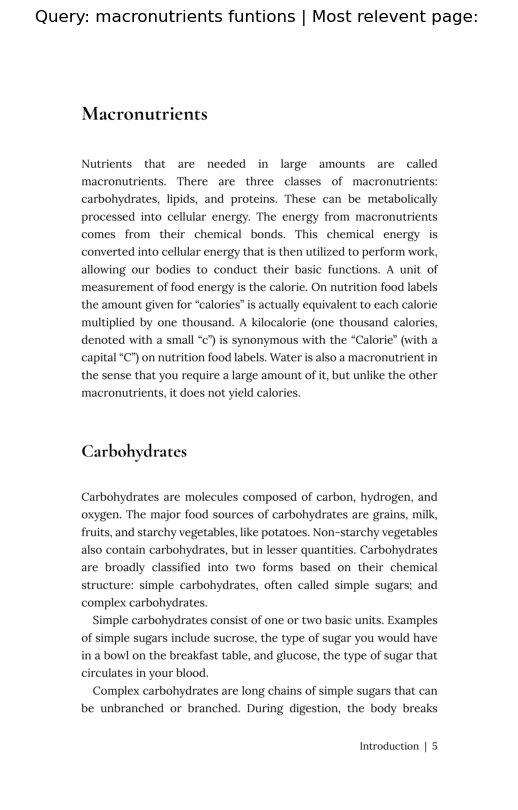

In [78]:
# check the top1 pdf page
import fitz

# open pdf and load target page
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)

# get the image of the page
img = page.get_pixmap(dpi=300)

# save the image
img.save("output_top1_page.png")
doc.close()

# convert the Pixmap to a numpy array
img_array = np.frombuffer(
    img.samples_mv,
    dtype=np.uint8
).reshape((img.h, img.w, img.n))

# display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevent page: ")
plt.axis("off")
plt.show()

点积运算和余弦相似度都是用来衡量向量之间相似度的方法，但它们的计算方式和理论依据有所不同，因此在某些情况下可能会产生不同的结果。

1. **点积运算**：
   - 点积，也称为内积或数量积，是两个向量对应分量的乘积之和。
   - 对于两个向量 $$\mathbf{a} = [a_1, a_2, ..., a_n]$$ 和 $$\mathbf{b} = [b_1, b_2, ..., b_n]$$，它们的点积定义为 $$a_1 \times b_1 + a_2 \times b_2 + ... + a_n \times b_n\$$。
   - 点积的值表示了两个向量之间的"方向"相似度和"长度"的关系，即它们的大小和方向有多么接近。

2. **余弦相似度**：
   - 余弦相似度是通过计算两个向量之间的夹角的余弦值来衡量它们的相似度。
   - 对于两个向量 a 和 b，它们的余弦相似度定义为 $$\frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}|| \times ||\mathbf{b}||}$$，其中 $$\mathbf{a} \cdot \mathbf{b}$$ 是它们的点积，而 $$||\mathbf{a}||$$ 和 $$||\mathbf{b}||$$ 分别是它们的范数（长度）。
   - 余弦相似度的取值范围在 -1 到 1 之间，取值越接近 1 表示两个向量的方向越相似，取值越接近 -1 表示它们的方向越相反，取值接近 0 表示它们的方向近乎垂直。

总的来说，点积更关注向量之间的"方向"和"长度"的关系，而余弦相似度更侧重于向量之间的方向相似度。

余弦相似度常用于以下几个领域和应用：

1. **信息检索和文本挖掘**：在信息检索系统中，余弦相似度用于衡量查询与文档之间的相似度，从而实现相关文档的检索。在文本挖掘中，余弦相似度常用于计算文本之间的相似性，如文档相似度、句子相似度等。

2. **推荐系统**：在协同过滤推荐算法中，余弦相似度常用于计算用户之间或物品之间的相似度，从而识别出相似的用户或物品，以实现个性化推荐。

3. **自然语言处理**：在文本分类、聚类、情感分析等任务中，余弦相似度被广泛应用于计算文本之间的相似度，以实现语义相似性的比较和判断。

4. **图像处理**：在图像检索、图像识别等任务中，余弦相似度可以用于比较图像的特征向量，从而识别出相似的图像。

5. **数据挖掘和机器学习**：在数据挖掘和机器学习中，余弦相似度常用于计算样本之间的相似度，以实现聚类、分类等任务。

6. **语音处理**：在语音识别、语音检索等任务中，余弦相似度可以用于比较语音信号的特征向量，从而识别出相似的语音片段。

总的来说，余弦相似度是一种通用的相似度度量方法，适用于各种领域和应用场景，特别是在高维空间中的数据分析和处理中具有广泛的应用。

## Functionizing our semantic search pipeline

In [83]:
from time import perf_counter as timer
def retrieve_relevant_resources(
    query: str,
    embeddings: torch.tensor,
    model: SentenceTransformer=embedding_model,
    n_resources_to_return: int=5,
    print_time:bool=True
):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

    scores, indices = torch.topk(
        input = dot_scores,
        k = n_resources_to_return
    )
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [84]:
# test the functions
query = "symptoms of pellagra"
# get the score and indices
score, indices = retrieve_relevent_resources(query=query, embeddings=embeddings)
score, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00028 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='mps:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='mps:0'))

In [85]:
# print out the texts of the top scores
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00010 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th

## GPU is not enough on my mac to run a llm

In [96]:
mps_memory_bytes = torch.mps.current_allocated_memory()
mps_memory_gb = round(mps_memory_bytes / (2**30))
print(f"{mps_memory_gb} GB :( check original Daniel's note book here ↓")

1 GB :( check original Daniel's note book here ↓


In [95]:
# https://github.com/mrdbourke/simple-local-rag/blob/main/00-simple-local-rag.ipynb
# https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV